In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import os
import sys
import pickle as pkl
import ast
import pandas as pd
import random
import json 
import pickle
from tqdm import tqdm
from scipy.sparse import lil_matrix
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
import math
import scanpy as sc
import anndata as ad
from scipy import stats
import squidpy as sq
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch, ArrowStyle
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True
import warnings
warnings.filterwarnings('ignore')  # Disable all warnings

In [2]:
import RegChat

# Load data

In [3]:
path = '/Users/lihuazhang/Documents/projects/RegChat/RegChat_code/Dataset/Skin/'
signaling_pathway = pd.read_csv(path + 'Skin_db.csv')
gene_cell_pd = pd.read_csv(path + 'PP/SCC_PP1_ST_expmat.csv',sep=',',index_col=0)
cell_type = pd.read_csv(path + 'PP/SCC_SSME_10_PP1_types.csv',sep='\t')
cell_type.index = gene_cell_pd.columns

In [4]:
# replace 'HLA-' to '.'
genes = gene_cell_pd.index.tolist()
genes_new = [s.replace('HLA-', 'HLA/') for s in genes]
gene_cell_pd.index = genes_new

In [5]:
Ls = signaling_pathway['Ligand_Symbol'].tolist()
Rs = signaling_pathway['Receptor_Symbol'].tolist()

Ls_new = [s.replace('HLA-', 'HLA/') for s in Ls]
Rs_new = [s.replace('HLA-', 'HLA/') for s in Rs]
signaling_pathway['Ligand_Symbol'] = Ls_new
signaling_pathway['Receptor_Symbol'] = Rs_new

In [6]:
X = gene_cell_pd.to_numpy()
coord = pd.read_csv(path + 'PP/SCC_PP1_ST_coord.csv',sep='\t',index_col=0)
intersection = list(set(coord.index.tolist()) & set(gene_cell_pd.columns.tolist()))

In [7]:
coord.index = gene_cell_pd.columns
# build adata for RNA-seq
obs = pd.DataFrame({
    'cell_type': cell_type['cell_type']
}, index= gene_cell_pd.columns)
var = pd.DataFrame({
    'gene_name': gene_cell_pd.index
}, index=gene_cell_pd.index)
# Initialize AnnData
adata_rna = ad.AnnData(X=X.T, obs=obs, var=var)
print(adata_rna)
adata_rna.obsm['spatial'] = coord.values
counts_type = obs['cell_type'].value_counts(dropna=False)
print(counts_type)

AnnData object with n_obs × n_vars = 987 × 2951
    obs: 'cell_type'
    var: 'gene_name'
cell_type
Keratinocyte    277
ECG             219
SMC             157
Endo            130
Fb              102
Myeloid          83
TC               19
Name: count, dtype: int64


[<Axes: title={'center': 'cell_type'}, xlabel='spatial1', ylabel='spatial2'>]

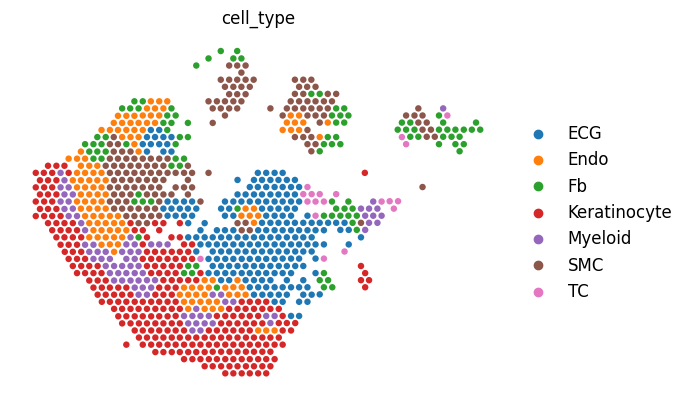

In [8]:
sc.pl.spatial(adata_rna, img_key=None, color=['cell_type'], 
                      legend_fontsize=12, show=False, frameon=False,
                      spot_size=20)

In [9]:
from RegChat import model
adata_rna_final = model.label_to_int(adata_rna)

In [10]:
spot_loc = pd.DataFrame(data = adata_rna_final.obsm['spatial'], index = adata_rna_final.obs.index, columns = ['x','y'])

In [11]:
gene_cell_pd = pd.DataFrame(data = adata_rna_final.X.T, index = adata_rna_final.var.index, columns = adata_rna_final.obs.index)

In [12]:
from RegChat import Train_CCC_model_no_intra

In [13]:
result_LR, LR_inter_activity_pd, CCI_strength_pd, CCI_mean,CCI_std, nei_adj = Train_CCC_model_no_intra(adata_rna = adata_rna_final, links_database = signaling_pathway, gene_cell_pd =gene_cell_pd,spot_loc=spot_loc, hidden_dim = 5, attn_drop = 0.0, layers_hidden=10, tau = 0.8, locMeasure='euclidean', lamb_1=1, lamb_2=1, lamb_3=1, mode = 'fast', no_label = False, no_spatial = False, neig_number=10, pure_cutoff = 0.1, sub_epochs=200, per_num_cut = None, epochs=500, lr=0.0001, weight_decay=0, use_cuda=0)

spot location for adjancy
Size of CCC pairs: 151
Start model training
10 cost: 6.4542418 relative decrease ratio: 0.0019582536
20 cost: 6.335808 relative decrease ratio: 0.0017673032
30 cost: 6.2310433 relative decrease ratio: 0.0015828807
40 cost: 6.141233 relative decrease ratio: 0.0013517587
50 cost: 6.063657 relative decrease ratio: 0.0012171782
60 cost: 5.9930525 relative decrease ratio: 0.0011415669
70 cost: 5.926984 relative decrease ratio: 0.0010882941
80 cost: 5.862914 relative decrease ratio: 0.0010841055
90 cost: 5.7993684 relative decrease ratio: 0.0010929358
100 cost: 5.7359643 relative decrease ratio: 0.0011026809
110 cost: 5.6722627 relative decrease ratio: 0.0011216769
120 cost: 5.6088467 relative decrease ratio: 0.0011233176
130 cost: 5.546667 relative decrease ratio: 0.0011034728
140 cost: 5.487145 relative decrease ratio: 0.0010548176
150 cost: 5.432144 relative decrease ratio: 0.00096623274
160 cost: 5.382266 relative decrease ratio: 0.00088621833
170 cost: 5.337031

# downstream analysis

In [14]:
from RegChat import utils

In [15]:
x = utils.neg_log10_transform(CCI_strength_pd.to_numpy(), replace_zero=1e-12)

In [16]:
var_lr = pd.DataFrame({
    'gene_name': CCI_strength_pd.columns
}, index=CCI_strength_pd.columns)
adata_rna_lr = ad.AnnData(X=x, obs=adata_rna_final.obs, var=var_lr)
adata_rna_lr

AnnData object with n_obs × n_vars = 987 × 151
    obs: 'cell_type', 'ref'
    var: 'gene_name'

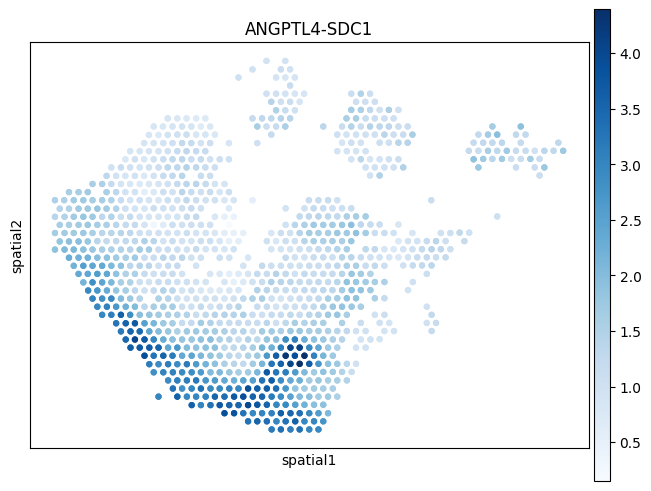

In [17]:
adata_rna_lr.obsm = adata_rna_final.obsm
sq.pl.spatial_scatter(
    adata_rna_lr,
    shape=None,
    color=["ANGPTL4-SDC1"],
    size=50,
    cmap = 'Blues' # Blues
   # save = os.path.join('/Users/lihuazhang/Documents/projects/RegChat/RegChat_code/Result/SCC/','COMP-SDC1_RegChat_NS.pdf')
)

# plot the direction only for the significant spots for focused L-R pair

In [18]:
from RegChat import analysis

In [19]:
p_val_cutoff = 0.05

In [20]:
res_df = analysis.get_signifcant_node(adata_rna_final,result_LR, nei_adj,coord,p_val_cutoff,type = 'mix',topk = 2)

In [21]:
label_list = ['Keratinocyte','Myeloid','TC','Endo','ECG','SMC','Fb']

In [22]:
color_map = {
    'Keratinocyte': '#CA3535',       # 蓝色
    'Myeloid':'#8A5A56',  # 橙色
    'TC': '#2F7EB7',  # 绿色
    'Endo': '#F57F31',     # 蓝色
    'ECG': '#45A648',  # 橙色
    'SMC': '#8B70B2',  # 绿色
    'Fb': '#D07CB3'
}
coord_df = coord.copy()
cell_type = adata_rna_final.obs['cell_type']

In [23]:
cell_type = cell_type.astype(str)
coord_df['color'] = cell_type.map(color_map)

In [24]:
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch, ArrowStyle

Text(0.5, 1.0, 'Communication Direction under: ANGPTL4-SDC1')

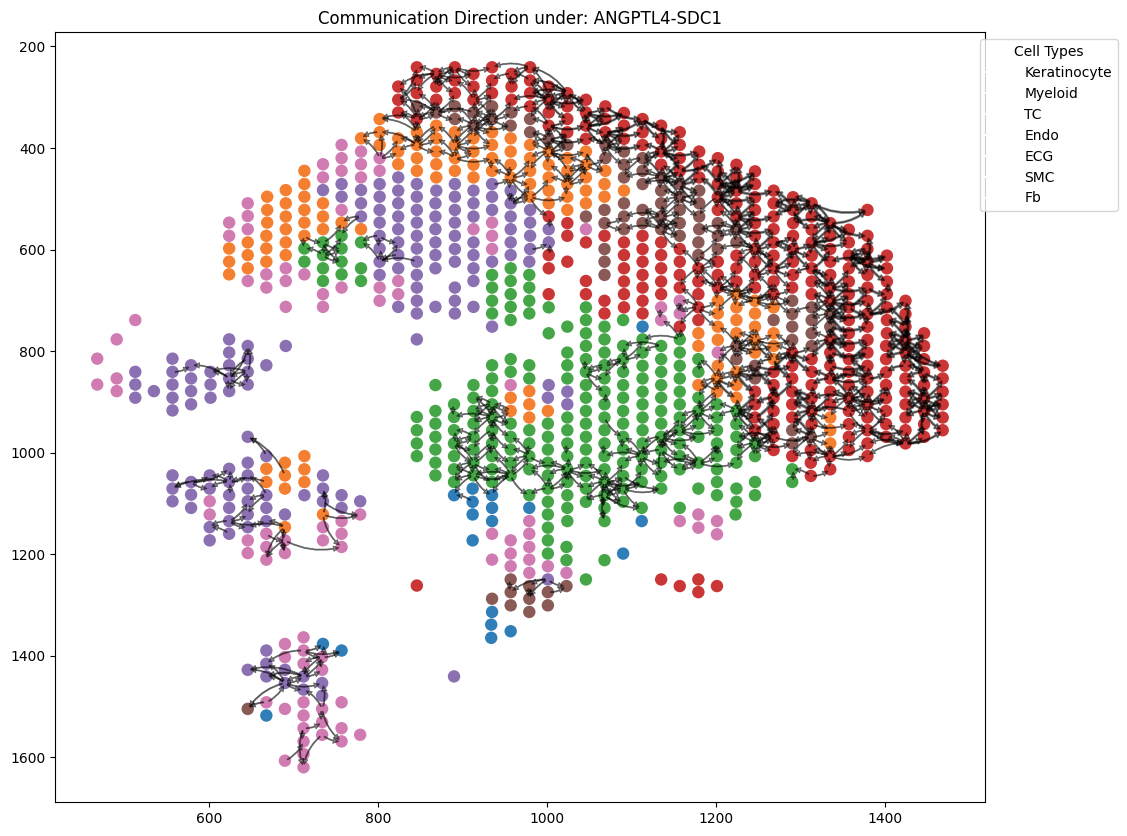

In [25]:
res_specific_df = res_df[res_df['LR_Name'].str.contains("ANGPTL4-SDC1")]
plt.figure(figsize=(12, 10))
scatter = plt.scatter(coord_df['y'], coord_df['x'],
                     c=coord_df['color'], alpha=1, s=80, linewidths=0) 
plt.gca().invert_yaxis() 
for index, row in res_specific_df.iterrows():
    strength = row['Comm_Score']
    lw = max(0.5, strength*0.1)
    arrowstyle = ArrowStyle("Simple", head_length=0.5, head_width=0.5, tail_width=0.1)
    arrow = FancyArrowPatch((row['Sender_y'],row['Sender_x']), 
                            (row['Receiver_y'], row['Receiver_x']),alpha=0.5,
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='black', lw=lw,
                            mutation_scale=8)
    plt.gca().add_patch(arrow)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=1)
           for celltype, color in color_map.items()]
plt.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.15, 1), loc= 'upper right')
plt.title('Communication Direction under: '+ "ANGPTL4-SDC1")